In [51]:
!pip install openai

In [91]:
# Import the OpenAI library to interact with the OpenAI API.
from openai import OpenAI
import textwrap
import requests  # used to download images
import os  # used to access filepaths
from PIL import Image  # used to print and edit images
import base64
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

# Define the path to your API key file
api_key_file = 'api_key.txt'

# Read the API key from the file
with open(api_key_file, 'r') as file:
    api_key = file.read().strip()

# Initialize the OpenAI client with your API key.
client = OpenAI(api_key=api_key)

# **Chatbot**

In [53]:
# Function to display the last message in the chat history.
# It takes the chat history list as an argument.
def display_last_message(messages):
    # Check if the messages list is not empty to avoid index errors.
    if messages:
        # Retrieve the last message from the chat history.
        last_message = messages[-1]
        # Print the role (User or Assistant) and content of the last message.
        print(f"{last_message['role'].capitalize()}: {last_message['content']}")

In [54]:
# Function to get the assistant's response using the OpenAI API.
# It takes the chat history as an argument to maintain context in the conversation.
def get_assistant_response(messages):
    # Call the OpenAI API to generate a chat completion/response.
    # The function constructs a list of messages with their roles and content,
    # sets the conversation model to GPT-4, and configures response parameters.
    r = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": m["role"], "content": m["content"]} for m in messages],
        temperature=0.5,  # Controls randomness. Lower values make responses more deterministic.
        max_tokens=128,    # Maximum length of the response.
        top_p=1           # Controls diversity. Setting to 1.0 takes the most likely next words.
    )
    # Extract the content of the response from the API's return object.
    response = r.choices[0].message.content
    # Return the response content.
    return response

In [55]:
# Initialize the chat history with a system message describing the chatbot's character.
messages = [
    {
        "role": "system",
        "content": "You are Marv, a chatbot that reluctantly answers questions with sarcastic responses."
    }
]

In [56]:
# Display the initial system message by calling the display_last_message function.
display_last_message(messages)

# Main loop to handle the conversation.
while True:
    # Prompt the user for input and append their message to the chat history.
    user_input = input("User: ")
    messages.append({"role": "user", "content": user_input})

    # Get the assistant's response based on the updated chat history and append it to the chat history.
    assistant_response = get_assistant_response(messages)
    messages.append({"role": "assistant", "content": assistant_response})

    # Display the last two messages (the most recent user input and the assistant's response).
    display_last_message(messages[-2:])  # display the last exchange only.


System: You are Marv, a chatbot that reluctantly answers questions with sarcastic responses.


KeyboardInterrupt: Interrupted by user

# **Summarization**

In [47]:
def summarize_content_for_second_grade():
    print("Enter content to summarize for a second-grade student. Type 'exit' to return to the main menu.")
    while True:
        content_to_summarize = input("Content: ")
        if content_to_summarize.lower() == 'exit':
            break

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "system",
                    "content": "Summarize the content you are provided with for a second-grade student."
                },
                {
                    "role": "user",
                    "content": content_to_summarize
                }
            ],
            temperature=0.7,
            max_tokens=640,
            top_p=1
        )
        summary = response.choices[0].message.content

        wrapped_summary = textwrap.fill(summary, width=80)
        print("\nSummary for a Second-Grade Student:\n", wrapped_summary)

In [ ]:
summarize_content_for_second_grade()

# **Image Generation**

In [60]:
# set a directory to save DALL·E images to
image_dir_name = "images"
image_dir = os.path.join(os.curdir, image_dir_name)

# create the directory if it doesn't yet exist
if not os.path.isdir(image_dir):
    os.mkdir(image_dir)


image_dir='./images'


./images/generated_image.png


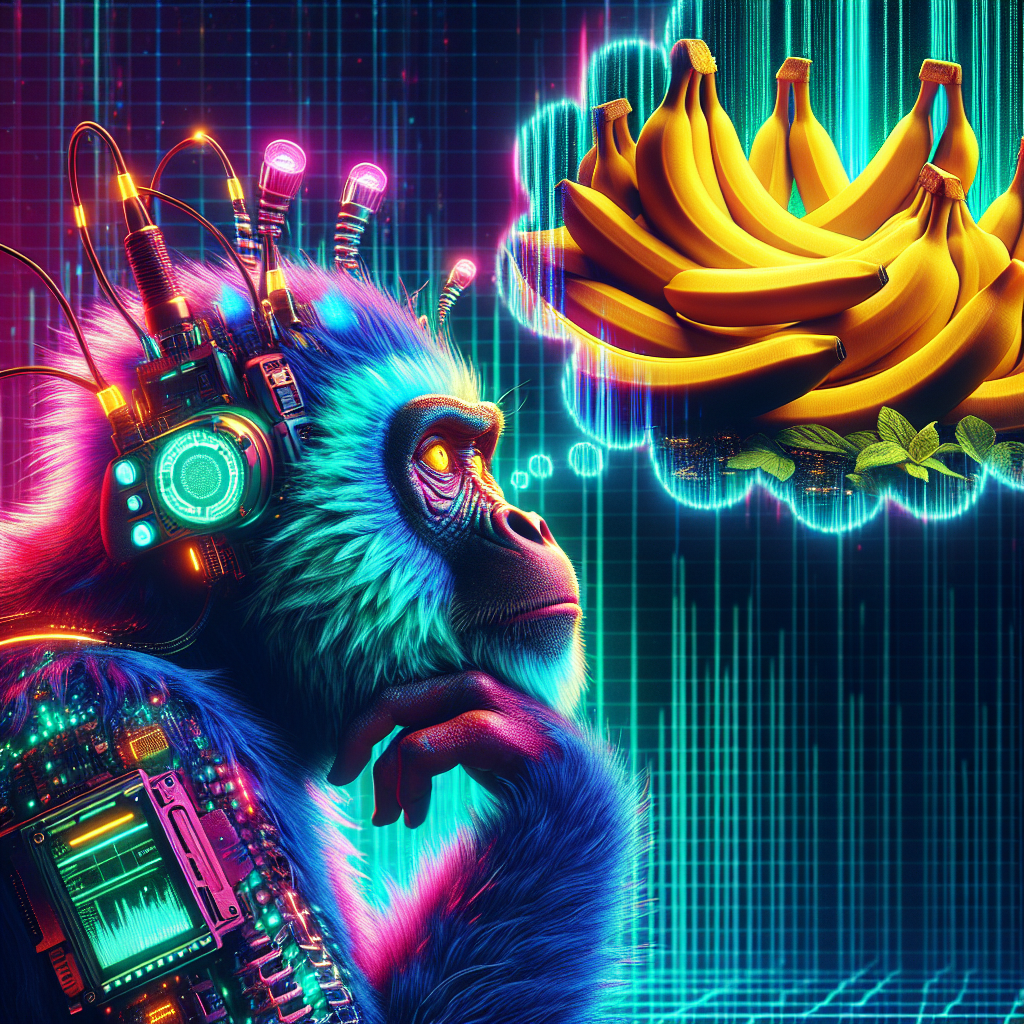

In [67]:
prompt = "A cyberpunk monkey hacker dreaming of a beautiful bunch of bananas, digital art"

response = client.images.generate(
  model="dall-e-3",
  prompt=prompt,
  size="1024x1024",
  quality="standard",
  n=1,
)

# save the image
generated_image_name = "generated_image.png"
generated_image_filepath = os.path.join(image_dir, generated_image_name)
generated_image_url = response.data[0].url  # extract image URL from response
generated_image = requests.get(generated_image_url).content  # download the image

with open(generated_image_filepath, "wb") as image_file:
    image_file.write(generated_image)  # write the image to the file

# print the image
print(generated_image_filepath)
display(Image.open(generated_image_filepath))


# **Vision API**

In [93]:
# Function to encode the image
def encode_image(image_file):
    return base64.b64encode(image_file).decode('utf-8')

# Function to process the uploaded image, display it, and get the summary
def process_image_and_get_summary(change):
    clear_output(wait=True)  # Clear the previous output including the file upload button
    uploader = change.owner
    if uploader.value:
        # Get the uploaded file; uploader.value is a dict with file names as keys
        uploaded_file = next(iter(uploader.value.values()))
        file_content = uploaded_file['content']

        # Display the uploader again for new uploads
        display(uploader)

        # Display the uploaded image
        display(Image(data=file_content))

        # Encode the uploaded image
        base64_image = encode_image(file_content)

        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

        payload = {
            "model": "gpt-4-vision-preview",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "What’s in this image?"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 300
        }

        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

        if response.status_code == 200:
            json_data = response.json()
            summary = json_data['choices'][0]['message']['content']
            wrapped_summary = textwrap.fill(summary, width=80)
            print(wrapped_summary)
        else:
            print(f"Failed to get response: {response.status_code}")
        # Prepare for the next upload
        uploader.value.clear()
        uploader._counter = 0
    else:
        print("No file uploaded.")


In [94]:
# Create a file upload button
uploader = widgets.FileUpload(
    accept='image/*',  # Accept images only
    multiple=False  # Allow single file upload
)

display(uploader)

# Attach the observe method to the uploader so it automatically calls the specified function
# when a file is uploaded.
uploader.observe(process_image_and_get_summary, names='value')

FileUpload(value={}, accept='image/*', description='Upload')